# Monte-Carlo simulation model

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import seaborn as sns
import faker
import isodate

In [78]:
plt.style.use('ggplot')

## Generate test data

In [5]:
fk = faker.Factory.create()

In [113]:
npr.seed(1)
n_recs = 110
data = []
for i in range(n_recs):
    payband = int(npr.choice([1, 2, 3], p=[0.7, 0.25, 0.05]))
    salary = 0
    if payband==1:
        salary = fk.random_int(min=60000, max=118000)
    elif payband==2:
        salary = fk.random_int(min=87000, max=160000)
    else:
        salary = fk.random_int(min=105000, max=200000)
    fte = npr.choice([1, 0.8, 0.6], p=[0.95, 0.025, 0.025])
    record = {
        'emp_id': i+1,
        'name': '{}, {}'.format(fk.last_name(), fk.first_name()),
        'hire_date': isodate.parse_date(fk.date()),
        'payband': payband,
        'salary': salary,
        'fte': fte
    }
    data.append(record)
# Reset seed to be truly random
npr.seed()

In [114]:
df = pd.DataFrame(data)
df.set_index('emp_id', inplace=True)
df['hire_date'] = pd.to_datetime(df.hire_date)
df['payband'] = df.payband.astype('category', categories=[1,2,3], ordered=True)
df = df[['name', 'hire_date', 'payband', 'salary', 'fte']]
df[:5]

,name,hire_date,payband,salary,fte
emp_id,,,,,
1,"Cooper, Kristin",1976-06-07,1,87866,1.0
2,"Mckinney, Sarah",2003-02-18,1,81221,1.0
3,"Clark, Evan",1977-02-09,1,100527,1.0
4,"Key, Jennifer",1999-03-09,1,113542,1.0
5,"Garrett, Lauren",2010-12-08,1,89731,1.0


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110 entries, 1 to 110
Data columns (total 5 columns):
name         110 non-null object
hire_date    110 non-null datetime64[ns]
payband      110 non-null category
salary       110 non-null int64
fte          110 non-null float64
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.4+ KB


## Overview analysis

In [287]:
payband_stats = df.groupby(['payband'])['salary','fte'].aggregate({'salary': [np.sum, np.min, np.max, np.median],
                                                                   'fte': [np.sum, 'count']})
payband_stats

salary                           fte      
             sum    amin    amax  median   sum count
payband                                             
1        7128538   60025  117775   85282  79.4    81
2        3117195   87688  159242  125656  24.8    25
3         569911  119317  167403  141595   4.0     4

In [119]:
print('Est Paybill: £{:,}'.format(df.salary.sum()))

Est Paybill: £10,815,644


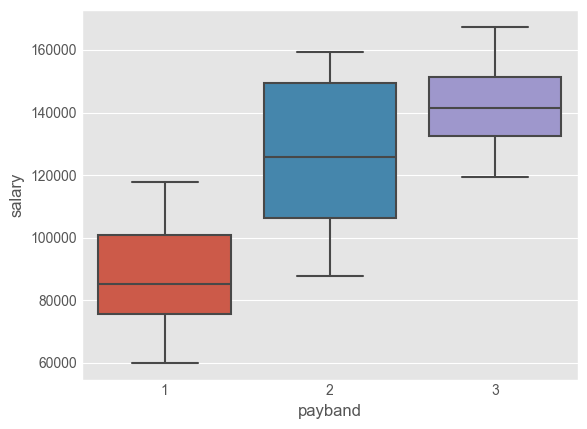

In [286]:
sns.boxplot(x='payband', y='salary', data=df)

## Random number generation

In [121]:
# Generate random number according to the specified probability distribution
def _generate_random(n=1):
    r_n = npr.choice(3, n, p=[.25, .65, .10])
    return r_n + 1

In [320]:
# Assign random group
df['random_group'] = _generate_random(n_recs)
df[:5]

,name,hire_date,payband,salary,fte,random_group
emp_id,,,,,,
1,"Cooper, Kristin",1976-06-07,1,87866,1.0,2
2,"Mckinney, Sarah",2003-02-18,1,81221,1.0,2
3,"Clark, Evan",1977-02-09,1,100527,1.0,1
4,"Key, Jennifer",1999-03-09,1,113542,1.0,2
5,"Garrett, Lauren",2010-12-08,1,89731,1.0,2


In [363]:
group_totals = df.groupby('random_group')['salary'].aggregate({'total': np.size})
group_totals['percent'] = group_totals.total/sum(group_totals.total)
group_totals

,total,percent
random_group,,
1,29,0.263636
2,71,0.645455
3,10,0.090909


## Pay uplift

### New pay ranges

In [326]:
new_ranges = pd.DataFrame({
    'payband': [1, 2, 3],
    'min': [69000, 87000, 105000],
    'max': [118000, 163000, 208100]
    })
new_ranges.set_index('payband', inplace=True)
new_ranges['midpoint'] = (new_ranges['max'] + new_ranges['min']) / 2
new_ranges

,max,min,midpoint
payband,,,
1,118000,69000,93500.0
2,163000,87000,125000.0
3,208100,105000,156550.0


In [327]:
# Eligible for uplift to new Min
uplift_df = df[(df['random_group'] < 3) & (df['hire_date'] < isodate.parse_date('2017-01-01'))]

In [328]:
def _apply_pay_uplift(row):
    pb = int(row.payband)
    new_min = new_ranges.get_value(pb, 'min')
    if new_min > row.salary:
        return new_min
    else:
        return row.salary

In [329]:
# Create new salary column 
# uplift_df = uplift_df.assign(new_salary=lambda df: df.salary)
uplift_df['new_salary'] = uplift_df.apply(_apply_pay_uplift, axis=1)
# uplift_df.loc[:,'new_salary'] = uplift_df.apply(_apply_pay_uplift, axis=1)

/Users/Joachim/.virtualenvs/pydev/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [330]:
uplift_df[:5]

,name,hire_date,payband,salary,fte,random_group,new_salary
emp_id,,,,,,,
1,"Cooper, Kristin",1976-06-07,1,87866,1.0,2,87866
2,"Mckinney, Sarah",2003-02-18,1,81221,1.0,2,81221
3,"Clark, Evan",1977-02-09,1,100527,1.0,1,100527
4,"Key, Jennifer",1999-03-09,1,113542,1.0,2,113542
5,"Garrett, Lauren",2010-12-08,1,89731,1.0,2,89731


In [331]:
'Cost of uplift: £{:,}'.format(sum(uplift_df.new_salary - uplift_df.salary))

'Cost of uplift: £50,969'

In [332]:
'Cost of uplift: {:,}%'.format((sum(uplift_df.new_salary - uplift_df.salary) / sum(uplift_df.salary)) * 100)

'Cost of uplift: 0.5345035804157905%'

In [386]:
plt.rcParams['figure.figsize'] = 6, 5

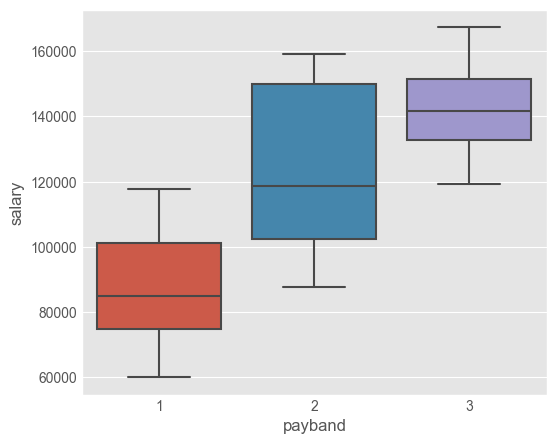

In [387]:
sns.boxplot(x='payband', y='salary', data=uplift_df)

In [334]:
df.groupby(['payband'])['salary','fte'].aggregate({'salary': [np.sum, np.min, np.max, np.median],
                                                                   'fte': [np.sum, 'count']})

salary                           fte      
             sum    amin    amax  median   sum count
payband                                             
1        7128538   60025  117775   85282  79.4    81
2        3117195   87688  159242  125656  24.8    25
3         569911  119317  167403  141595   4.0     4

In [339]:
uplift_df.groupby(['payband'])['new_salary','fte'].aggregate({'new_salary': [np.sum, np.min, np.max, np.median],
                                                                   'fte': [np.sum, 'count']})

new_salary                           fte      
               sum    amin    amax  median   sum count
payband                                               
1          6537527   69000  117775   85054  72.8    74
2          2479295   87688  159242  118574  19.8    20
3           569911  119317  167403  141595   4.0     4